In [7]:
import numpy as np
from numpy import sqrt
import pandas as pd
import random
import matplotlib.pyplot as plt
from skimage import measure
from tensorflow.keras.utils import to_categorical
import os
import math
import tqdm
import cv2 as cv
import enum

### Here is defined: 
width and height of the plotted implicit functions

boundaries for which the marching square isovalue still creates valid contours

shapes in the data set and equivalent numerical value which will be passed as a label to the data set

In [8]:
width, height = 28, 28

isoval_boundaries = {
"vertical_ellipse" : (1,7),
"horizontal_ellipse" : (1,7),
"heart" : (5,135),
"circle" : (25,169),
"hexagon" : (5,12),
"spiral" : (1.0,10.0)
}

shapes = {
"vertical_ellipse" : 1,
"horizontal_ellipse" : 2,
"heart" : 3,
"circle" : 4,
"hexagon" : 5,
"spiral":6
}

This function plots the implicit equations of different shapes in the cartesian coordinate system. Some functions like the spiral are naturally used in polar coordinates, hence a corvesion was made.  Since the coordinate systems are equivalent, there was no point in keeping track of both

In [9]:
#polar to cartesian: (r,θ)=(√x2+y2,tan−1(yx))
#cartesian to polar x = r × cos( θ ) y = r × sin( θ )
def get_shape_coords(name, x,y) -> float:
    if name == "heart":
        return (x**2 + (y - np.sqrt(np.abs(x))) ** 2)
    elif name == "circle" or name == "hexagon":  #hexagon and circle share the same implicit function
        return x**2 + y**2
    elif name == "vertical_ellipse":
        x = (x - 5)**2 / 9
        y = (y + 1)**2 / 16
        return x + y
    elif name == "horizontal_ellipse":
        x = (x + 1)**2 / 16
        y = (y - 5)**2 / 9
        return x + y
    elif name == "spiral":
        # r = aθ.
        r = np.sqrt(x**2 + y**2)
        theta = 0
        #avoid division by 0
        if (y != 0 and x !=0):
            theta = (math.atan(y / x))
            return 1 / r + theta * (x + y)
        return 0 

In [10]:
def pad_square_matrix(m, p):
    
    if (p == 0):
        return m
    offset = p - m.shape[1] 
    
    offset = offset // 2
    
    x = np.pad(m[0], offset, 'constant', constant_values=(0, 0))
    y = np.pad(m[1], offset, 'constant', constant_values=(0, 0))
    
    if (x.shape[0] != p):
        x = np.append(x, 0)
        y = np.append(y, 0)
    return np.array((x,y))

In [11]:
def get_implicit_cords(shape_name):
    a = []
    for w in range(-width // 2 ,width //2):
        for h in range(-height // 2 ,height // 2):
            a.append(get_shape_coords(shape_name,w,h))
        
    np_arr = np.array(a).reshape(width, height)
    return np_arr

Some implicit functions will need to be plotted on a polar coordinate system to display correctly

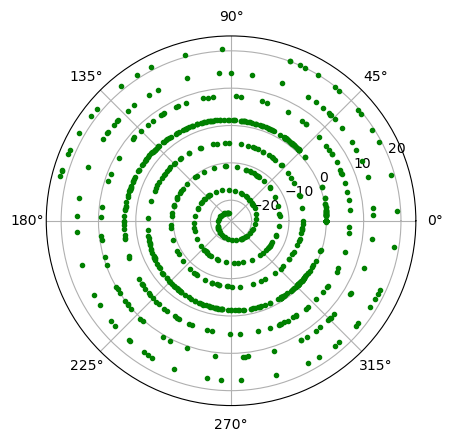

In [12]:
spiral = get_implicit_cords("spiral")

plt.axes(projection = 'polar')
  
# plotting the spiral
for rad in spiral:
    r = rad
    plt.polar(rad, r, 'g.')
      
# display the polar plot
plt.show()

In [13]:
def get_contour(implicit_cords, isoval):
    return np.array(measure.find_contours(implicit_cords, isoval))

In [14]:
def gen_uniform_dataset(sample_size, pad_size,):
    contours = []
    labels = []
    for shape_name in shapes.keys():
        isoval_bounds = isoval_boundaries[shape_name]
        isovals = []
        for i in range(sample_size):
            isovals.append(random.uniform(isoval_bounds[0], isoval_bounds[1]))

        for isoval in isovals:
            sample = measure.find_contours(get_implicit_cords(shape_name), isoval)
            
            sample = pad_square_matrix(sample, pad_size)
            contours.append(  [sample[0][:,0] ,sample[0][:,1] ])
            labels.append((shapes[shape_name]))
    return np.asarray(contours), np.asarray(labels)

In [15]:
def gen_images_from_contours(data, IMG_W=width, IMG_H=height, external_save = False, rgb = True):
    images = [] 
    
    if(external_save):
        if not os.path.exists("images"):
                    os.makedirs("images")

        for file in os.listdir("images"):
            if (file != ".ipynb_checkpoints"):
                os.remove(os.path.join("images", file))
                
    for img_i in tqdm.tqdm(range(len(data))):
        
        coords_converted = [
            (math.ceil(x), math.ceil(y))
            for x, y in zip(data[img_i][0], data[img_i][1])
        ]
        # create empty image
        image = np.zeros((IMG_W, IMG_H), np.uint8)
        if(rgb):
            image = np.zeros((IMG_W,IMG_H,3), 'uint8')
            # draw coordinates
            for i in range(IMG_W):
                for j in range(IMG_H):
                    if (i, j) in coords_converted:
                        if not(rgb):
                            image[i, j] = 255
                        else:
                            image[i,j, 0] = random.uniform(1,256)
                            image[i,j, 1] = random.uniform(1,256)
                            image[i,j, 2] = random.uniform(1,256)
        # print(coords_converted)
        image = cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)             
        images.append(image)
        
        if (external_save):
            # save image
            cv.imwrite("images/shape_{}.png".format(img_i + 1), image)
        
    return np.asarray(images)

In [712]:
df, dy = gen_uniform_dataset(1000, 0)

contours_as_images = gen_images_from_contours(df, external_save=False)
np.savez("dataset/shape_data" + ".npz", contours = contours_as_images, labels = dy)

/tmp/ipykernel_126761/837979566.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(contours), np.asarray(labels)
100%|█████████████████████████████████████| 6000/6000 [00:05<00:00, 1041.46it/s]


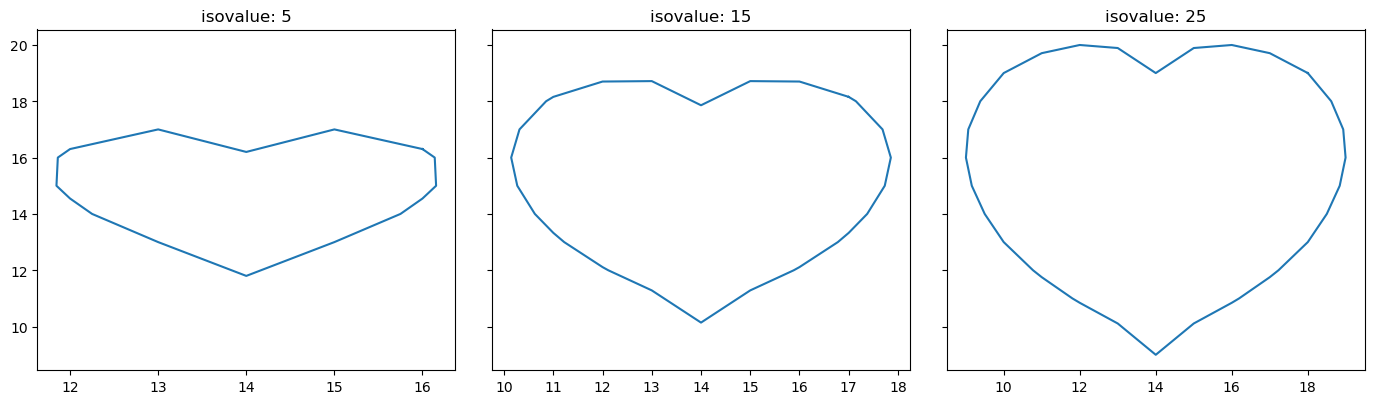

In [26]:
heart = get_implicit_cords("heart")


iso = [5, 15, 25]

f, ax = plt.subplots(1, 3,sharex='col', sharey='row' )
plt.rcParams["figure.figsize"] = (13,4)
plt.tight_layout()
curr = 0
for i in iso:
    cont = get_contour(heart, i)
    
    for contour in cont:
        ax[curr].plot(contour[:,0], contour[:,1])
        ax[curr].title.set_text("isovalue: " + str(i))
    curr +=1


In [686]:
contours = df[-1]
fig, ax = plt.subplots()

ax.plot(contours[0], contours[1], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()